In [1]:
%matplotlib inline
%pylab inline
import seaborn as sns

from collections import defaultdict
from constants import *
from os import listdir, makedirs
from os.path import join, isfile, exists, dirname
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from tqdm._tqdm_notebook import tqdm_notebook
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import TfidfModel, LdaModel
from gensim.models import Word2Vec, Doc2Vec, FastText
from utils import load
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from topic_reranking import TopicsLoader, Reranker

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tqdm_notebook.pandas()
pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000
pd.options.display.precision = 3
pd.options.display.width = 2000

Populating the interactive namespace from numpy and matplotlib


-----

### Loading embeddings

In [2]:
d2v = load('d2v').docvecs

Reading ../data/preprocessed/embeddings/d2v/d2v


In [3]:
w2v = load('w2v').wv

Reading ../data/preprocessed/embeddings/w2v/w2v


In [4]:
ftx = load('ftx').wv

Reading ../data/preprocessed/embeddings/ftx/ftx


In [5]:
d2v.init_sims()
# Dry run to make sure both indices are fully in RAM
vector = d2v.vectors_docs_norm[0]
print(d2v.index2entity[0])
d2v.most_similar([vector], topn=5)

8952056961092092653


[('8952056961092092653', 1.0),
 ('Alan_Smithee', 0.9754987955093384),
 ('-1104898985940030642', 0.5513984560966492),
 ('7742168460413119409', 0.5513654947280884),
 ('-7796041036897618663', 0.5506067276000977)]

In [6]:
w2v.init_sims()
# Dry run to make sure both indices are fully in RAM
vector = w2v.vectors_norm[0]
print(w2v.index2entity[0])
w2v.most_similar([vector], topn=5)

der


[('der', 1.0),
 ('.', 0.8032401204109192),
 ('und', 0.7845765948295593),
 (',', 0.7446213960647583),
 ('in', 0.7323893904685974)]

In [7]:
ftx.init_sims()
# Dry run to make sure both indices are fully in RAM
vector = ftx.vectors_norm[0]
print(ftx.index2entity[0])
ftx.most_similar([vector], topn=5)

der


[('der', 1.0),
 ('sich', 0.8626062870025635),
 ('jen', 0.8625022172927856),
 ('einen', 0.8589621782302856),
 ('und', 0.8401941061019897)]

In [8]:
kvs = {'d2v': d2v, 'w2v': w2v, 'ftx': ftx}

------

### Vector-based reranking

In [9]:
#nb_topics = 1
version = 'noun'
nb_candidate_terms = 20
nb_top_terms = 10

In [9]:
def _rank(df, name):
    df[f'{name}_drank'] = df[f'{name}_dscore'].rank().map(lambda x: x-1)
    df[f'{name}_rrank'] = df[f'{name}_rscore'].rank().map(lambda x: x-1)
    return df

def fillna_max(df):
    mask = df.isnull().any(axis=1)
    df[mask] = df[mask].apply(lambda x: x.fillna(x.max()), axis=1)
    return df

def rerank(topic_param):
    reference = pd.Series(np.arange(nb_candidate_terms), index=topic_param, name='ref_rank')
    scores = [reference]
    for name, kv in kvs.items():
        in_kv = np.vectorize(lambda x: x in kv)
        mask = in_kv(topic_param)
        topic = topic_param[mask]
        not_in_kv = topic_param[~mask]
        nb_terms_in_vocab = len(topic)
        rank_scores = defaultdict(int)
        dist_scores = defaultdict(float)
        for i in range(nb_terms_in_vocab):
            entity = topic[i]
            others = np.delete(topic, i)
            # print(entity, others)
            distances = kv.distances(entity, tuple(others))
            #print(distances)
            argsort = distances.argsort()
            #print(argsort)
            nearest = others[argsort]
            #print(entity, nearest)
            for j, term in zip(distances, others):
                dist_scores[term] += j
            for j, term in enumerate(nearest):
                rank_scores[term] += j
        d_score = pd.Series(dist_scores, name=f'{name}_dscore')
        r_score = pd.Series(rank_scores, name=f'{name}_rscore')
        dr = pd.concat([d_score, r_score], axis=1)
        dr = _rank(dr, name)
        #print(dr)
        scores.append(dr)
    df = pd.concat(scores, axis=1, sort=False)
    #print(df)
    if df.isnull().any().any():
        for s in ['dscore', 'rscore', 'drank', 'rrank']:
            scols = df.columns.str.contains(s)
            df.loc[:, scols] = fillna_max(df.loc[:, scols])
    #print('#' * 100)
    #print(df)
    
    # getting scores and ranks for all combinations -> calculating c = a+b for both distance and rank scores 
    # and getting a rank for the sum
    for c, a, b in [('dw', 'd2v', 'w2v'), ('df', 'd2v', 'ftx'), ('wf', 'w2v', 'ftx'), ('dwf', 'dw', 'ftx')]:
        df[f'{c}_dscore'] = df[f'{a}_dscore'] + df[f'{b}_dscore']
        df[f'{c}_rscore'] = df[f'{a}_rscore'] + df[f'{b}_rscore']
        df = _rank(df, c)

    #print(df)
    return df

def sort_terms(col):
    top_terms = col.sort_values().index.values[:nb_top_terms]
    col = col[col.index.isin(top_terms)]
    return col.index.values

def remove_not_matching_terms(kv_name, topic):
    kv = kvs[kv_name]
    reduced_tpx = topic

    in_kv = np.vectorize(lambda x: x in kv)
    mask = in_kv(topic)
    reduced_tpx = topic[mask]
    not_in_kv = topic[~mask]
    nb_terms_in_kv = len(reduced_tpx)
    if nb_terms_in_kv > nb_top_terms:
        for i in range(nb_terms_in_kv - nb_top_terms):
            remove = kv.doesnt_match(reduced_tpx)
            reduced_tpx = reduced_tpx[reduced_tpx != remove]
    elif nb_terms_in_kv == 0:
        print('ups')
        reduced_tpx = topic[:nb_top_terms]
    elif nb_terms_in_kv < nb_top_terms:
        print('obacht')
        nb_missing = nb_top_terms - nb_terms_in_kv
        for i, m in enumerate(mask):
            if not m:
                mask[i] = True
                nb_missing -= 1
                if nb_missing == 0:
                    break
        reduced_tpx = topic[mask]
    else:
        print('gleichstand')
        
    ser = pd.Series(reduced_tpx, name=kv_name + '_matches')
    return ser

def vote(df, reference, name='vote'):
    jury = (
        df
        .loc[:, 'term0':f'term{nb_top_terms-1}']
        .apply(pd.value_counts)
        .sum(axis=1)
        [reference]
        .dropna()
        .astype(np.int16)
        .reset_index()
        .rename(columns={'index':'term', 0:'count'})
        .sort_values('count', ascending=False, kind='mergesort')
        [:nb_top_terms]
        .set_index('term')
        .squeeze()
        [reference]
        .dropna()
        .reset_index()
        .rename(lambda x: f'term{x}')
        .drop('count', axis=1)
        .squeeze()
        .rename(name)
    )
    return jury

def calc_oop(col, df_ranks):
    terms = col.values
    ref_ranks = df_ranks.loc[terms, 'ref_rank']
    oop = (ref_ranks - np.arange(len(ref_ranks))).abs().sum()
    return oop

def full_rerank_and_everything(topic):
    topic = topic.values[0]

    df = rerank(topic)
    rank_columns = [col for col in df.columns if 'rank' in col]
    df_ranks = df[rank_columns]
    reranks = df_ranks.apply(sort_terms, axis=0).reset_index(drop=True).T.rename(columns=lambda x: f'term{x}')

    dred = remove_not_matching_terms('d2v', topic)
    wred = remove_not_matching_terms('w2v', topic)
    fred = remove_not_matching_terms('ftx', topic)
    reds = pd.concat([dred, wred, fred], axis=1).T.rename(columns=lambda x: f'term{x}')
    reranks = pd.concat([reranks, reds])

    votes = []
    for name in ['rrank', 'drank', 'matches', '']:
        x = reranks[reranks.index.str.contains(name)]
        v = vote(x, topic, f'{name}_vote'.strip('_'))
        votes.append(v)
    reranks = reranks.append(votes)

    reranks['oop_scores'] = reranks.apply(lambda x: calc_oop(x, df_ranks), axis=1)
    return reranks

def plot(scores):
    sns.set()
    pylab.rcParams['figure.figsize'] = (40, 15)
    scores.boxplot()

In [10]:
def score_and_plot(topics):
    result = topics.groupby(level=[0, 1, 2, 3], sort=False).progress_apply(full_rerank_and_everything)
    result.index = result.index.rename(names='metric', level=-1)
    scores = result.oop_scores.unstack('metric')
    #scores.describe()
    plot(scores)
    return result

param_ids = ['e42']
nbs_topics = [10, 25, 50, 100]

topics = []
for dataset in ['dewa1', 'O', 'news', 'speeches', 'FA', 'FO', 'E', 'P']:
    topics_loader = TopicsLoader(
        dataset=dataset,
        param_ids=param_ids,
        nbs_topics=nbs_topics,
        version=version,
        topn=nb_candidate_terms
    )
    topics.append(topics_loader.topics)

topics = pd.concat(topics)

loading dictionary from ../data/preprocessed/LDAmodel/noun/dewac_nbfiles01_noun_bow.dict
loading corpus from ../data/preprocessed/LDAmodel/noun/dewac_nbfiles01_noun_bow.mm
loading texts from ../data/preprocessed/LDAmodel/noun/dewac_nbfiles01_noun_bow_texts.json
Loading model from ../data/preprocessed/LDAmodel/noun/e42/dewac_nbfiles01_LDAmodel_e42_100
loading dictionary from ../data/preprocessed/LDAmodel/noun/OnlineParticipation_noun_bow.dict
loading corpus from ../data/preprocessed/LDAmodel/noun/OnlineParticipation_noun_bow.mm
loading texts from ../data/preprocessed/LDAmodel/noun/OnlineParticipation_noun_bow_texts.json
Loading model from ../data/preprocessed/LDAmodel/noun/e42/OnlineParticipation_LDAmodel_e42_100
loading dictionary from ../data/preprocessed/LDAmodel/noun/news_noun_bow.dict
loading corpus from ../data/preprocessed/LDAmodel/noun/news_noun_bow.mm
loading texts from ../data/preprocessed/LDAmodel/noun/news_noun_bow_texts.json
Loading model from ../data/preprocessed/LDAmodel/

gleichstand
gleichstand
obacht
gleichstand
gleichstand



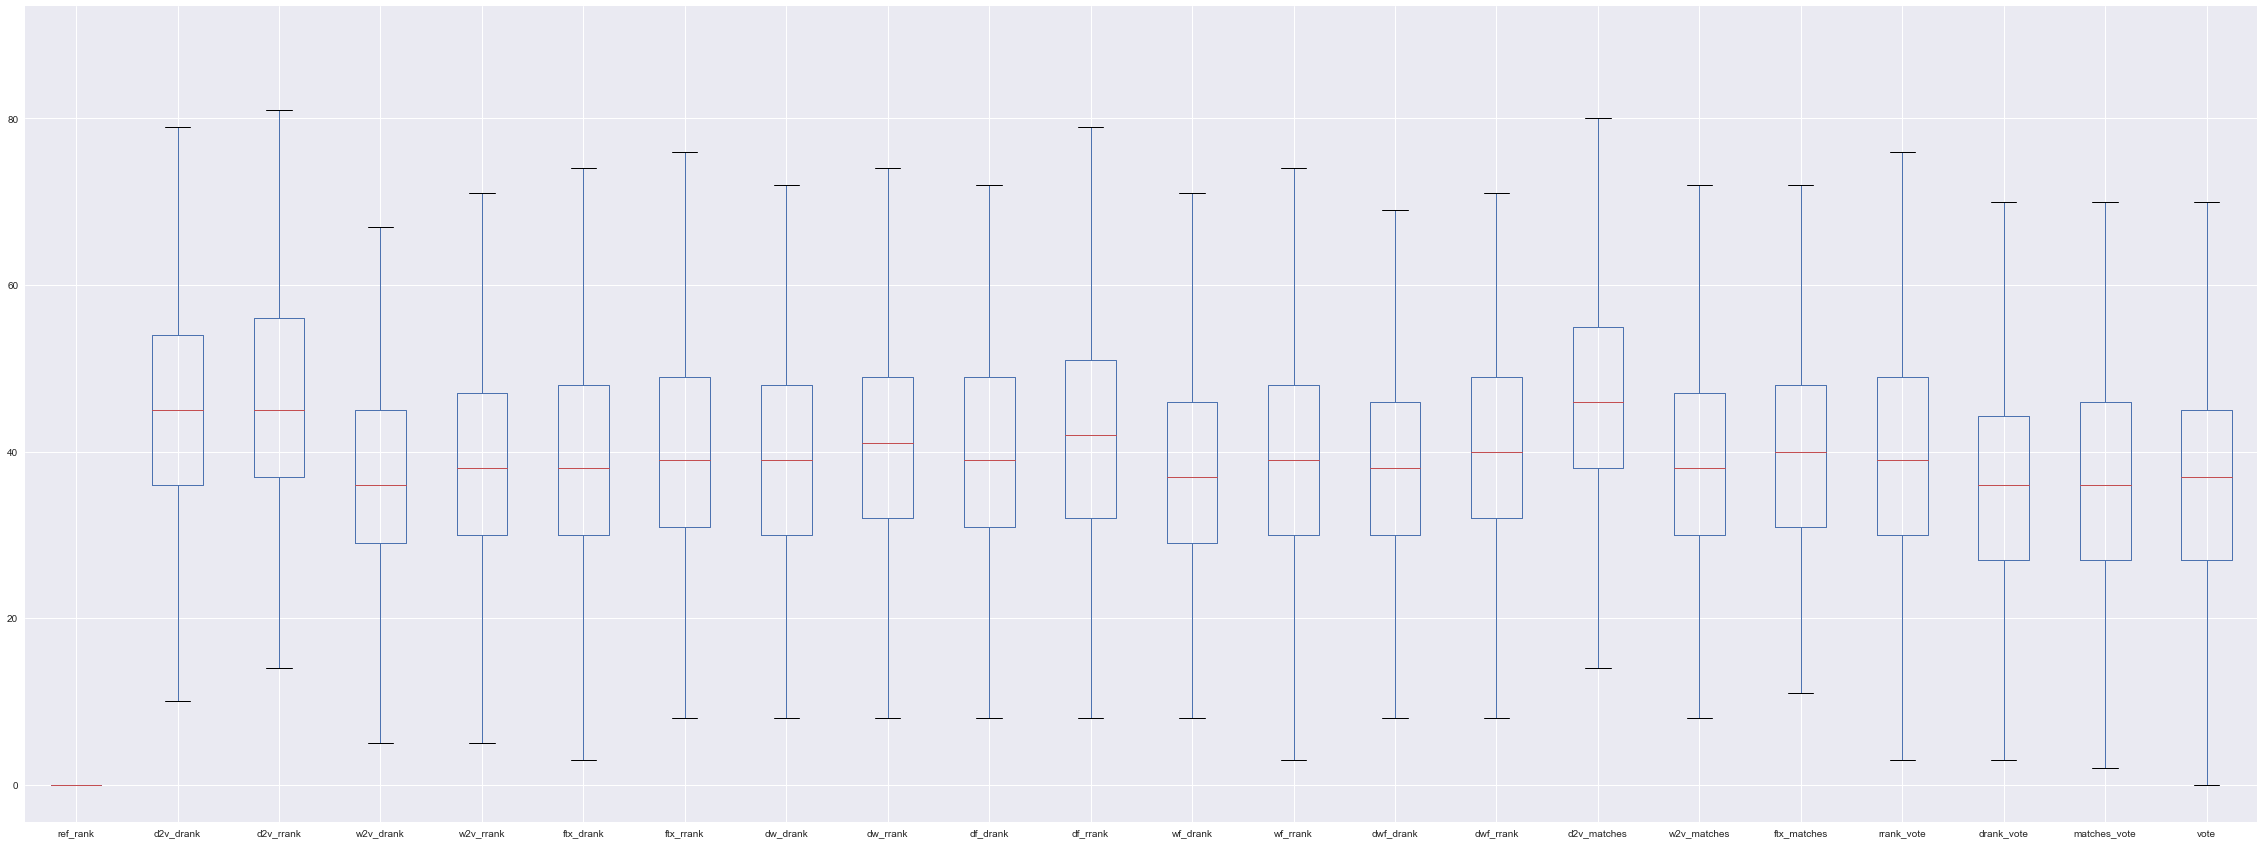

In [11]:
results = score_and_plot(topics)

In [12]:
results.to_csv(join(TPX_PATH, ))
results

term0  \
dataset         param_id nb_topics topic_idx metric                              
dewac_nbfiles01 e42      100       0         ref_rank                   Partei   
                                             d2v_drank                  Partei   
                                             d2v_rrank                  Partei   
                                             w2v_drank                  Partei   
                                             w2v_rrank                  Partei   
                                             ftx_drank                  Partei   
                                             ftx_rrank                  Partei   
                                             dw_drank                   Partei   
                                             dw_rrank                   Partei   
                                             df_drank                   Partei   
                                             df_rrank                   Partei   
                                             wf_drank                   Partei   
                                             wf_rrank                   Partei   
                                             dwf_drank                  Partei   
                                             dwf_rrank                  Partei   
                                             d2v_matches                   PDS   
                                             w2v_matches                Partei   
                                             ftx_matches                Partei   
                                             rrank_vote                 Partei   
                                             drank_vote                 Partei   
                                             matches_vote               Partei   
                                             vote                       Partei   
                                   1         ref_rank                    König   
                                             d2v_drank                    Frau   
                                             d2v_rrank                    Frau   
                                             w2v_drank                    Frau   
                                             w2v_rrank                   König   
                                             ftx_drank                    Frau   
                                             ftx_rrank                    Frau   
                                             dw_drank                     Frau   
                                             dw_rrank                    König   
                                             df_drank                     Frau   
                                             df_rrank                     Frau   
                                             wf_drank                     Frau   
                                             wf_rrank                     Frau   
                                             dwf_drank                    Frau   
                                             dwf_rrank                   König   
                                             d2v_matches                  Frau   
                                             w2v_matches                 König   
                                             ftx_matches                 König   
                                             rrank_vote                  König   
                                             drank_vote                   Frau   
                                             matches_vote                König   
                                             vote                         Frau   
                                   2         ref_rank      Lebenspartnerschaft   
                                             d2v_drank     Lebenspartnerschaft   
                                             d2v_rrank     Lebenspartnerschaft   
                                             w2v_drank 

-----

# Vector-based topic quality rating

### everything from here has been implemented and can be deleted

In [22]:
topics = load('topics', 'gur')
topics

Reading ../data/preprocessed/gurevych_datasets.csv


,,Word1,Word2
,Dataset,,
1,gur350,Absage,Stellenanzeige
2,gur350,Affe,Gepäckkontrolle
3,gur350,Affe,Makake
5,gur350,Agentur,Irrtum
6,gur350,Airbag,Kopfairbag
8,gur350,Ansehen,Schaden
9,gur350,Arbeitssuchender,Bewerbung
11,gur350,Aufpreis,Grundpreis
12,gur350,Aufstieg,Erfolg


In [56]:
def cosine_similarities(vector_1, vectors_all):
    """Compute cosine similarities between one vector and a set of other vectors.

    Parameters
    ----------
    vector_1 : numpy.ndarray
        Vector from which similarities are to be computed, expected shape (dim,).
    vectors_all : numpy.ndarray
        For each row in vectors_all, distance from vector_1 is computed, expected shape (num_vectors, dim).

    Returns
    -------
    numpy.ndarray
        Contains cosine distance between `vector_1` and each row in `vectors_all`, shape (num_vectors,).

    """
    norm = np.linalg.norm(vector_1)
    #if vectors_all.shape[0] > 1:
    all_norms = np.linalg.norm(vectors_all, axis=1)
    #else:
    #all_norms = np.linalg.norm(vectors_all)
    dot_products = dot(vectors_all, vector_1)
    similarities = dot_products / (norm * all_norms)
    return similarities

def pairwise_similarity(topic, ignore_oov=True):
    similarities = dict()
    for name, kv in kvs.items():
        vector = lambda x: kv[x] if x in kv else np.nan
        vectors = topic.map(vector).dropna()
        if len(vectors) < 2:
            similarities[name] = np.nan
            continue
        vectors = vectors.apply(pd.Series).values
        sims = np.asarray([cosine_similarities(vec, vectors) for vec in vectors]).mean(axis=0)
        if not ignore_oov:
            missing = len(topic) - len(sims)
            if missing > 0:
                sims = np.append(sims, np.zeros(missing))
        similarity = sims.mean()
        similarities[name] = similarity
    return pd.Series(similarities)

def mean_similarity(topic):
    similarities = dict()
    for name, kv in kvs.items():
        vector = lambda x: kv[x] if x in kv else np.nan
        vectors = topic.map(vector).dropna()
        if len(vectors) < 2:
            similarities[name] = np.nan
            continue
        vectors = vectors.apply(pd.Series).values
        mean_vec = np.mean(vectors, axis=0)
        similarity = cosine_similarities(mean_vec, vectors).mean()
        similarities[name] = similarity
    return pd.Series(similarities)

def pair_similarity(topic):
    similarities = dict()
    for name, kv in kvs.items():
        vector = lambda x: kv[x] if x in kv else np.nan
        vectors = topic.map(vector).dropna()
        vectors = vectors.apply(pd.Series).values
        mean_vec = np.mean(vectors, axis=0)
        similarity = cosine_similarities(mean_vec, vectors).mean()
        similarities[name] = similarity
    return pd.Series(similarities)

kv = ftx
results = topics
if topics.shape[1] == 2:
    pass
ms = results.progress_apply(mean_similarity, axis=1)
ps = results.progress_apply(pairwise_similarity, axis=1)
ps2 = results.progress_apply(lambda x: pairwise_similarity(x, ignore_oov=False), axis=1)

In [29]:
ftx.most_similar(positive=['König', 'Frau'], negative=['Mann'])

[('Gemahlin', 0.7497044801712036),
 ('Königin', 0.7478883266448975),
 ('Tochter_der_König', 0.7252410054206848),
 ('Prinzessin', 0.7014725804328918),
 ('Gemahl', 0.6783015727996826),
 ('Königshaus', 0.6703982353210449),
 ('Königstochter', 0.6701529622077942),
 ('Thronbesteigung', 0.6688751578330994),
 ('Königspaar', 0.6671768426895142),
 ('Der_König', 0.6662001609802246)]

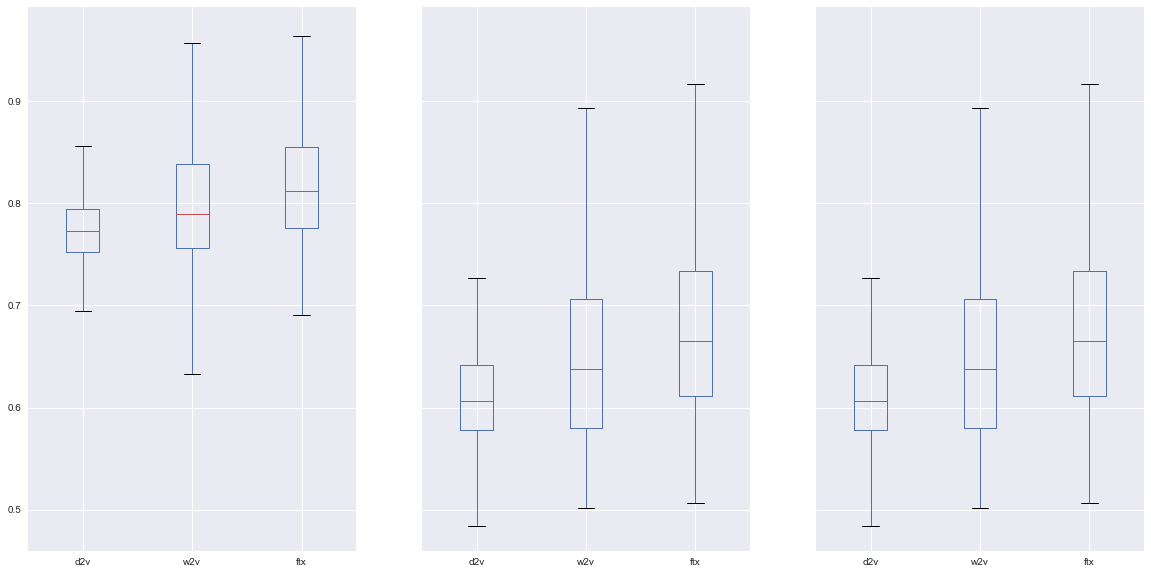

In [57]:
sns.set()
pylab.rcParams['figure.figsize'] = (20, 10)
fig, axs = subplots(ncols=3, sharey=True)
ms.boxplot(ax=axs[0])
ps.boxplot(ax=axs[1])
ps2.boxplot(ax=axs[2])

In [13]:
ms

d2v    w2v    ftx
dataset             param_id nb_topics topic_idx                     
OnlineParticipation e42      100       0          0.517  0.543  0.589
                                       1          0.570  0.506  0.575
                                       2          0.540  0.519  0.611
                                       3          0.530  0.535  0.568
                                       4          0.455  0.524  0.576
                                       5          0.566  0.477  0.535
                                       6          0.498  0.504  0.565
                                       7          0.529  0.557  0.606
                                       8          0.502  0.507  0.582
                                       9          0.570  0.502  0.531
                                       10         0.517  0.492  0.528
                                       11         0.545  0.591  0.630
                                       12         0.527  0.479  0.534
                                       13         0.493  0.511  0.570
                                       14         0.575  0.487  0.559
                                       15         0.580  0.531  0.595
                                       16         0.497  0.519  0.563
                                       17         0.501  0.528  0.559
                                       18         0.536  0.472  0.524
                                       19         0.570  0.643  0.688
                                       20         0.512  0.500  0.551
                                       21         0.491  0.481  0.546
                                       22         0.509  0.462  0.529
                                       23         0.468  0.551  0.587
                                       24         0.545  0.464  0.516
                                       25         0.554  0.536  0.602
                                       26         0.536  0.521  0.576
                                       27         0.529  0.487  0.536
                                       28         0.541  0.520  0.577
                                       29         0.491  0.470  0.543
                                       30         0.490  0.446  0.487
                                       31         0.495  0.483  0.524
                                       32         0.497  0.447  0.497
                                       33         0.529  0.455  0.497
                                       34         0.521  0.513  0.556
                                       35         0.597  0.525  0.565
                                       36         0.492  0.446  0.511
                                       37         0.538  0.505  0.559
                                       38         0.601  0.515  0.572
                                       39         0.532  0.487  0.541
                                       40         0.501  0.429  0.476
                                       41         0.495  0.465  0.520
                                       42         0.523  0.659  0.694
                                       43         0.501  0.426  0.509
                                       44         0.685  0.532  0.584
                                       45         0.486  0.457  0.526
                                       46         0.613  0.592  0.654
                                       47         0.571  0.441  0.510
                                       48         0.545  0.516  0.583
                                       49         0.589  0.493  0.547
                                       50         0.512  0.538  0.588
                                       51         0.472  0.502  0.543
                                       52         0.537  0.469  0.538
                                       53         0.554  0.487  0.535
                                       54         0.536  0.501  0.562
                                       55         0.503  0.500

In [14]:
ps

d2v    w2v    ftx
dataset             param_id nb_topics topic_idx                     
OnlineParticipation e42      100       0          0.279  0.299  0.349
                                       1          0.326  0.269  0.334
                                       2          0.298  0.286  0.378
                                       3          0.285  0.292  0.326
                                       4          0.209  0.279  0.335
                                       5          0.322  0.242  0.296
                                       6          0.252  0.264  0.324
                                       7          0.283  0.317  0.371
                                       8          0.252  0.260  0.341
                                       9          0.349  0.255  0.283
                                       10         0.270  0.250  0.296
                                       11         0.308  0.352  0.398
                                       12         0.280  0.239  0.291
                                       13         0.248  0.266  0.328
                                       14         0.338  0.241  0.315
                                       15         0.341  0.289  0.356
                                       16         0.249  0.276  0.321
                                       17         0.251  0.282  0.315
                                       18         0.290  0.234  0.281
                                       19         0.341  0.424  0.482
                                       20         0.265  0.256  0.307
                                       21         0.246  0.242  0.302
                                       22         0.259  0.231  0.290
                                       23         0.222  0.309  0.348
                                       24         0.300  0.226  0.273
                                       25         0.313  0.292  0.364
                                       26         0.292  0.279  0.335
                                       27         0.287  0.245  0.292
                                       28         0.293  0.277  0.336
                                       29         0.243  0.234  0.299
                                       30         0.245  0.207  0.241
                                       31         0.248  0.240  0.278
                                       32         0.255  0.206  0.249
                                       33         0.284  0.211  0.251
                                       34         0.273  0.268  0.314
                                       35         0.359  0.280  0.323
                                       36         0.244  0.208  0.267
                                       37         0.292  0.263  0.316
                                       38         0.372  0.274  0.330
                                       39         0.284  0.248  0.297
                                       40         0.265  0.199  0.237
                                       41         0.248  0.230  0.278
                                       42         0.274  0.439  0.484
                                       43         0.253  0.198  0.268
                                       44         0.474  0.291  0.345
                                       45         0.240  0.220  0.282
                                       46         0.392  0.354  0.430
                                       47         0.346  0.217  0.273
                                       48         0.300  0.273  0.341
                                       49         0.357  0.255  0.306
                                       50         0.266  0.291  0.346
                                       51         0.225  0.255  0.297
                                       52         0.298  0.238  0.299
                                       53         0.320  0.246  0.294
                                       54         0.289  0.255  0.319
                                       55         0.258  0.253

In [15]:
ps2

d2v    w2v    ftx
dataset             param_id nb_topics topic_idx                     
OnlineParticipation e42      100       0          0.223  0.299  0.349
                                       1          0.294  0.269  0.334
                                       2          0.298  0.286  0.378
                                       3          0.200  0.292  0.326
                                       4          0.209  0.279  0.335
                                       5          0.257  0.242  0.296
                                       6          0.202  0.264  0.324
                                       7          0.255  0.317  0.371
                                       8          0.202  0.260  0.341
                                       9          0.140  0.204  0.283
                                       10         0.243  0.225  0.296
                                       11         0.215  0.352  0.398
                                       12         0.196  0.239  0.291
                                       13         0.173  0.266  0.328
                                       14         0.304  0.241  0.315
                                       15         0.239  0.289  0.356
                                       16         0.224  0.276  0.321
                                       17         0.226  0.282  0.315
                                       18         0.232  0.234  0.281
                                       19         0.273  0.424  0.482
                                       20         0.238  0.256  0.307
                                       21         0.222  0.242  0.302
                                       22         0.182  0.231  0.290
                                       23         0.178  0.309  0.348
                                       24         0.270  0.203  0.273
                                       25         0.313  0.292  0.364
                                       26         0.204  0.279  0.335
                                       27         0.258  0.245  0.292
                                       28         0.205  0.277  0.336
                                       29         0.219  0.234  0.299
                                       30         0.172  0.207  0.241
                                       31         0.198  0.216  0.278
                                       32         0.204  0.206  0.249
                                       33         0.227  0.211  0.251
                                       34         0.191  0.268  0.314
                                       35         0.287  0.280  0.323
                                       36         0.195  0.208  0.267
                                       37         0.204  0.263  0.316
                                       38         0.261  0.274  0.330
                                       39         0.255  0.248  0.297
                                       40         0.239  0.179  0.237
                                       41         0.224  0.230  0.278
                                       42         0.247  0.439  0.484
                                       43         0.228  0.198  0.268
                                       44         0.190  0.291  0.345
                                       45         0.216  0.220  0.282
                                       46         0.235  0.354  0.430
                                       47         0.242  0.217  0.273
                                       48         0.210  0.273  0.341
                                       49         0.285  0.255  0.306
                                       50         0.239  0.291  0.346
                                       51         0.203  0.255  0.297
                                       52         0.238  0.238  0.299
                                       53         0.224  0.222  0.294
                                       54         0.260  0.255  0.319
                                       55         0.232  0.253

In [18]:
pd.concat({'mean_similarity': ms, 'pairwise_similarity_ignore_oov': ps, 'pairwise_similarity': ps2}, axis=1)

mean_similarity               pairwise_similarity               pairwise_similarity_ignore_oov              
                                                             d2v    w2v    ftx                 d2v    w2v    ftx                            d2v    w2v    ftx
dataset             param_id nb_topics topic_idx                                                                                                             
OnlineParticipation e42      100       0                   0.517  0.543  0.589               0.223  0.299  0.349                          0.279  0.299  0.349
                                       1                   0.570  0.506  0.575               0.294  0.269  0.334                          0.326  0.269  0.334
                                       2                   0.540  0.519  0.611               0.298  0.286  0.378                          0.298  0.286  0.378
                                       3                   0.530  0.535  0.568               0.200  0.292  0.326                          0.285  0.292  0.326
                                       4                   0.455  0.524  0.576               0.209  0.279  0.335                          0.209  0.279  0.335
                                       5                   0.566  0.477  0.535               0.257  0.242  0.296                          0.322  0.242  0.296
                                       6                   0.498  0.504  0.565               0.202  0.264  0.324                          0.252  0.264  0.324
                                       7                   0.529  0.557  0.606               0.255  0.317  0.371                          0.283  0.317  0.371
                                       8                   0.502  0.507  0.582               0.202  0.260  0.341                          0.252  0.260  0.341
                                       9                   0.570  0.502  0.531               0.140  0.204  0.283                          0.349  0.255  0.283
                                       10                  0.517  0.492  0.528               0.243  0.225  0.296                          0.270  0.250  0.296
                                       11                  0.545  0.591  0.630               0.215  0.352  0.398                          0.308  0.352  0.398
                                       12                  0.527  0.479  0.534               0.196  0.239  0.291                          0.280  0.239  0.291
                                       13                  0.493  0.511  0.570               0.173  0.266  0.328                          0.248  0.266  0.328
                                       14                  0.575  0.487  0.559               0.304  0.241  0.315                          0.338  0.241  0.315
                                       15                  0.580  0.531  0.595               0.239  0.289  0.356                          0.341  0.289  0.356
                                       16                  0.497  0.519  0.563               0.224  0.276  0.321                          0.249  0.276  0.321
                                       17                  0.501  0.528  0.559               0.226  0.282  0.315                          0.251  0.282  0.315
                                       18                  0.536  0.472  0.524               0.232  0.234  0.281                          0.290  0.234  0.281
                                       19                  0.570  0.643  0.688               0.273  0.424  0.482                          0.341  0.424  0.482
                                       20                  0.512  0.500  0.551               0.238  0.256  0.307                          0.265  0.256  0.307
                                       21                  0.491  0.481  0.546               0.222  0.242  0.302                          0.246  0.242  0.302
                                       22                  0.509  0.462  0.529               0.182 

In [58]:
print(ms.mean(axis=0))
print(ps.mean(axis=0))
print(ps2.mean(axis=0))

d2v    0.774
w2v    0.799
ftx    0.818
dtype: float64
d2v    0.614
w2v    0.652
ftx    0.678
dtype: float64
d2v    0.614
w2v    0.652
ftx    0.678
dtype: float64


In [74]:
f1 = '/media/andreas/Sounds/workspace/master_cloud/corpora/preprocessed/LDAmodel/noun/bow/topics/gur_noun_bow_topic-scores.csv'
f2 = '/media/andreas/Sounds/workspace/master_cloud/corpora/preprocessed/LDAmodel/noun/bow/topics/gur_noun_bow_topic-score_1544384181.csv'
df1 = pd.read_csv(f1, header=[0, 1], index_col=[0, 1]).sort_index(level='dataset')
df2 = pd.read_csv(f2, header=[0, 1], index_col=[0, 1]).sort_index(level='dataset')

In [75]:
df1

score                                            stdev                                        support                                      
                  c_v_wikt c_npmi_wikt c_uci_wikt c_uci_wikt_w20   c_v_wikt c_npmi_wikt c_uci_wikt c_uci_wikt_w20 c_v_wikt c_npmi_wikt c_uci_wikt c_uci_wikt_w20
dataset topic_idx                                                                                                                                               
gur222  3            0.709  -3.430e-01     -9.477          0.358  1.595e-07           0          0              0        2           2          2              2
        4            0.774   1.046e-01      1.390          1.372  2.320e-09           0          0              0        2           2          2              2
        5            0.401  -1.953e-01     -5.398         -6.856  2.351e-05           0          0              0        2           2          2              2
        11           0.631  -2.496e-01     -6.897         -8.210  6.800e-08           0          0              0        2           2          2              2
        12           0.433  -1.948e-01     -5.382         -6.683  1.236e-05           0          0              0        2           2          2              2
        13           0.714   1.681e-02      0.297          0.189  2.630e-08           0          0              0        2           2          2              2
        14           0.708  -5.363e-02     -0.936         -0.574  3.494e-08           0          0              0        2           2          2              2
        15           0.405  -2.018e-01     -5.576         -6.926  1.859e-01           0          0              0        2           2          2              2
        17           0.701  -5.628e-02     -0.611         -0.455  1.363e-10           0          0              0        2           2          2              2
        18           0.799   9.630e-02      1.232          1.236  1.228e-08           0          0              0        2           2          2              2
        20           0.485  -1.182e-01     -3.267         -4.483  2.564e-03           0          0              0        2           2          2              2
        21           0.695  -1.915e-02     -0.254         -0.222  1.263e-10           0          0              0        2           2          2              2
        22           0.776   8.421e-02      0.986          0.920  6.861e-10           0          0              0        2           2          2              2
        24           0.389  -2.375e-01     -6.562         -7.894  5.808e-05           0          0              0        2           2          2              2
        25           0.731  -3.541e-02     -0.543         -0.115  4.948e-09           0          0              0        2           2          2              2
        27           0.690  -5.059e-02     -0.681         -0.431  1.756e-09           0          0              0        2           2          2              2
        29           0.686  -5.115e-02     -0.546         -0.402  7.825e-12           0          0              0        2           2          2              2
        31           0.755   4.938e-03      0.077          0.093  2.054e-09           0          0              0        2           2          2              2
        34           0.784  -3.386e-01     -9.356          0.811  1.444e-07           0          0              0        2           2          2              2
        36           0.755   8.859e-02      0.917          0.787  1.295e-10           0          0              0        2           2          2              2
        37           0.377  -2.371e-01     -6.550         -7.897  1.356e-06           0          0              0        2           2          2              2
        38           0.904   3.502e-01      5.728          5.834  2.500e-07           0          0              0        2           2          2            

In [76]:
df2

score                stdev              support           mean_similarity               pairwise_similarity               pairwise_similarity_ignore_oov              
                  c_w2v_w2v c_w2v_ftx  c_w2v_w2v  c_w2v_ftx c_w2v_w2v c_w2v_ftx             d2v    w2v    ftx                 d2v    w2v    ftx                            d2v    w2v    ftx
dataset topic_idx                                                                                                                                                                           
gur222  3             0.735     0.736  7.645e-02  7.095e-02         2         2             NaN  0.735  0.736                 NaN  0.547  0.548                            NaN  0.547  0.548
        4             0.814     0.841  2.093e-02  2.817e-02         2         2             NaN  0.814  0.841                 NaN  0.664  0.710                            NaN  0.664  0.710
        5             0.701     0.737  1.654e-01  8.723e-02         2         2             NaN  0.701  0.737                 NaN  0.521  0.552                            NaN  0.521  0.552
        11            0.764     0.785  7.936e-02  6.585e-02         2         2           0.703  0.764  0.785               0.520  0.594  0.624                          0.520  0.594  0.624
        12            0.818     0.849  3.288e-02  1.804e-02         2         2             NaN  0.818  0.849                 NaN  0.671  0.721                            NaN  0.671  0.721
        13            0.756     0.786  3.931e-02  2.061e-02         2         2             NaN  0.756  0.786                 NaN  0.574  0.618                            NaN  0.574  0.618
        14            0.723     0.750  1.510e-02  3.166e-03         2         2             NaN  0.723  0.750                 NaN  0.523  0.563                            NaN  0.523  0.563
        15            1.000     1.000  0.000e+00  0.000e+00         1         1             NaN    NaN  0.773                 NaN    NaN  0.614                            NaN    NaN  0.614
        17            0.752     0.786  1.315e-01  1.139e-01         2         2           0.778  0.752  0.786               0.607  0.590  0.640                          0.607  0.590  0.640
        18            0.781     0.812  4.785e-02  2.305e-02         2         2             NaN  0.781  0.812                 NaN  0.614  0.661                            NaN  0.614  0.661
        20            1.000     1.000  0.000e+00  0.000e+00         1         1             NaN    NaN  0.824                 NaN    NaN  0.681                            NaN    NaN  0.681
        21            0.730     0.766  1.118e-02  1.585e-04         2         2           0.750  0.730  0.766               0.595  0.533  0.588                          0.595  0.533  0.588
        22            0.805     0.824  5.094e-02  3.100e-02         2         2           0.750  0.805  0.824               0.566  0.654  0.681                          0.566  0.654  0.681
        24            0.725     0.756  1.107e-01  3.970e-02         2         2             NaN  0.725  0.756                 NaN  0.539  0.573                            NaN  0.539  0.573
        25            0.763     0.799  1.225e-02  6.640e-03         2         2             NaN  0.763  0.799                 NaN  0.582  0.638                            NaN  0.582  0.638
        27            0.754     0.764  7.327e-02  6.030e-02         2         2             NaN  0.754  0.764                 NaN  0.576  0.589                            NaN  0.576  0.589
        29            0.753     0.783  5.121e-04  3.149e-03         2         2           0.705  0.753  0.783               0.523  0.567  0.614                          0.523  0.567  0.614
        31            0.756     0.778  1.494e-02  2.810e-02         2         2             NaN  0.756  0.778                 NaN  0.572  0.607                            NaN  0.572  0.607
        34            0.796     0.819  4.966e-02  4.4

In [83]:
df = df1.join(df2)[['score', 'stdev', 'support', 'mean_similarity', 'pairwise_similarity', 'pairwise_similarity_ignore_oov']]
df

score                                                                stdev                                                              support                                                           mean_similarity               pairwise_similarity               pairwise_similarity_ignore_oov              
                  c_v_wikt c_npmi_wikt c_uci_wikt c_uci_wikt_w20 c_w2v_w2v c_w2v_ftx   c_v_wikt c_npmi_wikt c_uci_wikt c_uci_wikt_w20  c_w2v_w2v  c_w2v_ftx c_v_wikt c_npmi_wikt c_uci_wikt c_uci_wikt_w20 c_w2v_w2v c_w2v_ftx             d2v    w2v    ftx                 d2v    w2v    ftx                            d2v    w2v    ftx
dataset topic_idx                                                                                                                                                                                                                                                                                                                          
gur222  3            0.709  -3.430e-01     -9.477          0.358     0.735     0.736  1.595e-07           0          0              0  7.645e-02  7.095e-02        2           2          2              2         2         2             NaN  0.735  0.736                 NaN  0.547  0.548                            NaN  0.547  0.548
        4            0.774   1.046e-01      1.390          1.372     0.814     0.841  2.320e-09           0          0              0  2.093e-02  2.817e-02        2           2          2              2         2         2             NaN  0.814  0.841                 NaN  0.664  0.710                            NaN  0.664  0.710
        5            0.401  -1.953e-01     -5.398         -6.856     0.701     0.737  2.351e-05           0          0              0  1.654e-01  8.723e-02        2           2          2              2         2         2             NaN  0.701  0.737                 NaN  0.521  0.552                            NaN  0.521  0.552
        11           0.631  -2.496e-01     -6.897         -8.210     0.764     0.785  6.800e-08           0          0              0  7.936e-02  6.585e-02        2           2          2              2         2         2           0.703  0.764  0.785               0.520  0.594  0.624                          0.520  0.594  0.624
        12           0.433  -1.948e-01     -5.382         -6.683     0.818     0.849  1.236e-05           0          0              0  3.288e-02  1.804e-02        2           2          2              2         2         2             NaN  0.818  0.849                 NaN  0.671  0.721                            NaN  0.671  0.721
        13           0.714   1.681e-02      0.297          0.189     0.756     0.786  2.630e-08           0          0              0  3.931e-02  2.061e-02        2           2          2              2         2         2             NaN  0.756  0.786                 NaN  0.574  0.618                            NaN  0.574  0.618
        14           0.708  -5.363e-02     -0.936         -0.574     0.723     0.750  3.494e-08           0          0              0  1.510e-02  3.166e-03        2           2          2              2         2         2             NaN  0.723  0.750                 NaN  0.523  0.563                            NaN  0.523  0.563
        15           0.405  -2.018e-01     -5.576         -6.926     1.000     1.000  1.859e-01           0          0              0  0.000e+00  0.000e+00        2           2          2              2         1         1             NaN    NaN  0.773                 NaN    NaN  0.614                            NaN    NaN  0.614
        17           0.701  -5.628e-02     -0.611         -0.455     0.752     0.786  1.363e-10           0          0              0  1.315e-01  1.139e-01        2           2          2              2         2         2           0.778  0.752  0.786               0.607  0.590  0.640                          0.607  0.590  0.640
        18           0.799   9.630e-0